In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym
from custom_envs import RandomWalker1D
from custom_agents import AgentGrad
from scipy.ndimage import gaussian_filter1d

In [3]:
class ShortCorridorGridworld():
    def __init__(self):
        self.state = 0
        self.a_right = torch.tensor([1, 0], dtype=torch.float).reshape(2, 1)
        self.a_left = torch.tensor([0, 1], dtype=torch.float).reshape(2, 1)

    def step(self, a):
        if (a > 1) or (a < 0):
            raise ValueError('a can only be integer 0 or 1.')
        r = -1
        terminated = False
        new_state = self.state
        if self.state == 0:
            if a == 0:  # right
                new_state += 1
        elif self.state == 1:  # Reverse action
            if a == 0:  # a=right, becomes left
                new_state -= 1
            elif a == 1:  # a=left, becomes right
                new_state += 1
        elif self.state == 2:
            if a ==0:
                new_state += 1
            elif a == 1:
                new_state -= 1
        elif self.state == 3:  # Terminal state
            if a == 1:
                new_state -= 1
        else:
            raise ValueError('Action based on undefined state.')
        if new_state == 3:
            terminated = True
        self.state = new_state
        
        return self.state, r, terminated
    
    def reset(self):
        self.state = 0
        return self.state
    
            


    

# Policy Gradient on Short Corridor Grid World

In [13]:
# Monte-carlo
Q_model = torch.nn.Sequential(
    nn.Linear(2, 1), # 0
    nn.Softmax(dim=0)
)
torch.nn.init.normal_(Q_model[0].weight, 0, 1e-5)

env = ShortCorridorGridworld()
amat = torch.eye(2, dtype=torch.float, requires_grad=False)
gamma = 1
alpha = 2 ** (-15)
Niters = 20000
all_totalt = np.zeros(Niters)
all_totalG = np.zeros(Niters)

for ni in range(Niters):
    if (ni % 1000 == 0):
        print(ni, t, a_probs_np)

    env.reset()
    Q_model.zero_grad()
    terminated = False
    all_t = []
    all_a = []
    all_R = []
    t = 0

    with torch.no_grad():
        a_probs = Q_model(amat)
    a_probs_np = a_probs.detach().numpy().squeeze()

    while terminated is False:
        a = np.random.choice([0, 1], p=a_probs_np)
        _, r, terminated = env.step(a)
        all_t.append(t)
        all_a.append(a)
        all_R.append(r)
        t += 1

    L = len(all_t)
    for k in range(L):
        ep_t = all_t[k]
        ep_a = all_a[k]
        ep_r = all_R[k]
        
        
        G_t = np.sum([ all_R[j] * (gamma ** (j-k))  for j in range(k, L)])

        if k ==0:
            all_totalG[ni] = G_t
        

        a_probs = Q_model(amat)
        log_aprob_this = torch.log(a_probs[ep_a])
        log_aprob_this.backward()
        with torch.no_grad():
            Q_model[0].weight += alpha * (gamma ** ep_t) * G_t * Q_model[0].weight.grad
        Q_model.zero_grad()


    all_totalt[ni] = all_t[-1]



0 4 [0.3739488 0.6260512]
1000 8 [0.5297874  0.47021264]
2000 6 [0.5499213  0.45007876]
3000 5 [0.561992   0.43800798]
4000 3 [0.5819517 0.4180483]
5000 7 [0.5950311  0.40496886]
6000 32 [0.60205734 0.39794266]
7000 19 [0.59739083 0.40260917]
8000 4 [0.5814462  0.41855383]
9000 3 [0.58395785 0.41604218]
10000 17 [0.5715705 0.4284295]
11000 4 [0.58758223 0.41241777]
12000 8 [0.59095585 0.40904415]
13000 3 [0.5792557  0.42074436]
14000 15 [0.5865559  0.41344407]
15000 7 [0.58487964 0.41512033]
16000 20 [0.59581375 0.40418628]
17000 4 [0.6001965  0.39980355]
18000 3 [0.5951438  0.40485623]
19000 24 [0.58976746 0.4102325 ]


(0.0, 1000.0)

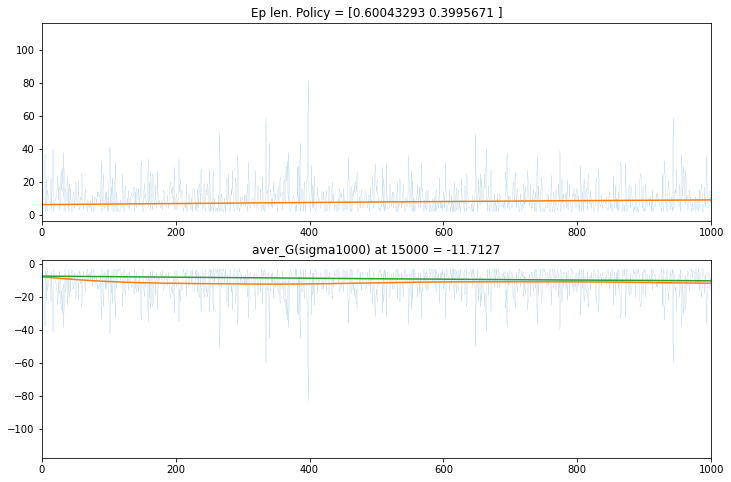

In [17]:
aver_t = gaussian_filter1d(all_totalt, sigma=1000, mode='nearest')
aver_G = gaussian_filter1d(all_totalG, sigma=1000, mode='nearest')
aver_G2 = gaussian_filter1d(all_totalG, sigma=100, mode='nearest')
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(all_totalt, lw=0.1)
ax[1].plot(all_totalG, lw=0.1)
ax[0].plot(aver_t)
ax[1].plot(aver_G2)
ax[1].plot(aver_G)

# ax[1].set_ylim(-20, 0)
ax[0].set_title('Ep len. Policy = %s'%(str(a_probs_np)))
ax[1].set_title('aver_G(sigma1000) at 15000 = %0.4f'%(aver_G[15000]))

ax[0].set_xlim(0, 1000)
ax[1].set_xlim(0, 1000)

# REINFORCE with Baseline

In [9]:
# Monte-carlo
Q_model = torch.nn.Sequential(
    nn.Linear(2, 1), # 0
    nn.Softmax(dim=0)
)
torch.nn.init.normal_(Q_model[0].weight, 0, 1e-5)

w = torch.normal(torch.tensor([0.0]), torch.tensor([1e-5]))

env = ShortCorridorGridworld()
amat = torch.eye(2, dtype=torch.float, requires_grad=False)
gamma = 1
alpha_theta = 2 ** (-9)
alpha_w = 2**(-6)
Niters = 20000
all_totalt = np.zeros(Niters)
all_totalG = np.zeros(Niters)

for ni in range(Niters):
    if (ni % 1000 == 0) & (ni > 0):
        print(ni, t, a_probs_np)

    env.reset()
    Q_model.zero_grad()
    terminated = False
    all_t = []
    all_a = []
    all_R = []
    t = 0

    with torch.no_grad():
        a_probs = Q_model(amat)
    a_probs_np = a_probs.detach().numpy().squeeze()

    while terminated is False:
        a = np.random.choice([0, 1], p=a_probs_np)
        _, r, terminated = env.step(a)
        all_t.append(t)
        all_a.append(a)
        all_R.append(r)
        t += 1

    L = len(all_t)
    for k in range(L):
        ep_t = all_t[k]
        ep_a = all_a[k]
        ep_r = all_R[k]
        
        
        G_t = np.sum([ all_R[j] * (gamma ** (j-k))  for j in range(k, L)])

        if k ==0:
            all_totalG[ni] = G_t
        
        tderr = G_t - w
        w = w + alpha_w * tderr

        a_probs = Q_model(amat)
        log_aprob_this = torch.log(a_probs[ep_a])
        log_aprob_this.backward()
        with torch.no_grad():
            Q_model[0].weight += alpha_theta * (gamma ** ep_t) * tderr * Q_model[0].weight.grad
        Q_model.zero_grad()


    all_totalt[ni] = all_t[-1]



1000 3 [0.579699   0.42030108]
2000 11 [0.62665075 0.3733492 ]
3000 3 [0.6671639  0.33283606]
4000 12 [0.46358782 0.5364122 ]
5000 3 [0.58849317 0.41150683]
6000 10 [0.5168566 0.4831434]
7000 12 [0.59960926 0.40039077]
8000 3 [0.64980096 0.350199  ]
9000 7 [0.6062918  0.39370826]
10000 19 [0.67068225 0.32931772]
11000 5 [0.6340874  0.36591265]
12000 11 [0.4552174 0.5447826]
13000 20 [0.65652287 0.34347716]
14000 12 [0.592422 0.407578]
15000 15 [0.6795478  0.32045227]
16000 4 [0.5716198 0.4283802]
17000 12 [0.6774056  0.32259443]
18000 3 [0.49318823 0.5068118 ]
19000 7 [0.6554809 0.3445191]


Text(0.5, 1.0, 'aver_G(sigma1000) at 15000 = -12.1219')

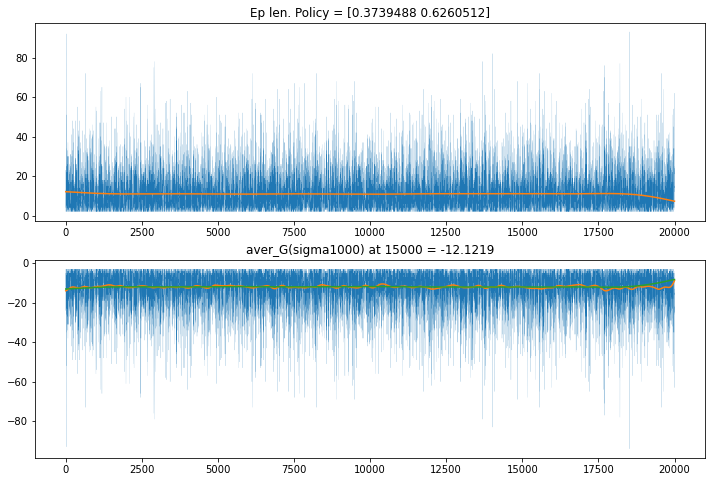

In [12]:
aver_t = gaussian_filter1d(all_totalt, sigma=1000, mode='nearest')
aver_G = gaussian_filter1d(all_totalG, sigma=1000, mode='nearest')
aver_G2 = gaussian_filter1d(all_totalG, sigma=100, mode='nearest')
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(all_totalt, lw=0.1)
ax[1].plot(all_totalG, lw=0.1)
ax[0].plot(aver_t)
ax[1].plot(aver_G2)
ax[1].plot(aver_G)

# ax[1].set_ylim(-20, 0)
ax[0].set_title('Ep len. Policy = %s'%(str(a_probs_np)))
ax[1].set_title('aver_G(sigma1000) at 15000 = %0.4f'%(aver_G[15000]))

In [18]:
w

tensor([-9.9624])